In [1]:
from __future__ import division

import time
import datetime

from scipy.spatial.distance import cdist
from scipy.interpolate import interp1d
from scipy.stats import mode
import numpy as np
import pandas as pd

#scikit-learn
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import AgglomerativeClustering
from sklearn import datasets
from sklearn.ensemble.partial_dependence import plot_partial_dependence

#h-stat
from sklearn_gbmi import *

#matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

#altair
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

# Data Loading Functions

In [2]:
#for reproducibility
np.random.seed(2019)
#functions to parse included datasets
def load_bike_dataset():
    def _datestr_to_timestamp(s):
        return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d").timetuple())

    data = pd.read_csv('data/bike.csv')
    data['dteday'] = data['dteday'].apply(_datestr_to_timestamp)
    data = pd.get_dummies(data, prefix=["weathersit"], columns=["weathersit"], drop_first=False)
    
    #de-normalize data to produce human-readable features.
    #Original range info from http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset
    data["hum"] = data["hum"].apply(lambda x: x*100.)
    data["windspeed"] = data["windspeed"].apply(lambda x: x*67.)
    #convert Celsius to Fahrenheit
    data["temp"] = data["temp"].apply(lambda x: (x*47. - 8)*9/5 +32)
    data["atemp"] = data["atemp"].apply(lambda x: (x*66. - 16)*9/5 + 32)
    
    #rename features to make them interpretable for novice users
    feature_names_dict = {"yr":"First or Second Year", 
                              "season":"Season", 
                              "hr":"Hour of Day", 
                              "workingday":"Work Day",
                              "weathersit_2":"Misty Weather",
                              "weathersit_3":"Light Precipitation",
                              "weathersit_4":"Heavy Precipitation",
                              "temp":"Temperature (F)",
                              "atemp":"Feels Like (F)",
                              "hum":"Humidity",
                              "windspeed":"Wind Speed"}
    data= data.rename(mapper=feature_names_dict,axis=1)
    
    features = ['yr', 'season', 'hr', 'workingday',
                'weathersit_2', 'weathersit_3', 'weathersit_4',
                'temp', 'atemp', 'hum', 'windspeed']  
    
    features = feature_names_dict.values()

    X = data[features]
    y = data['cnt']

    return X, y

def load_diabetes_dataset():
    diabetes_dataset = datasets.load_diabetes()

    return pd.DataFrame(diabetes_dataset.data, columns=diabetes_dataset.feature_names), diabetes_dataset.target  

def load_boston_dataset():
    boston_dataset = datasets.load_boston()

    return pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names), boston_dataset.target    

def load_dataset(name="bike"):
    
    if name =="bike":
        X,y = load_bike_dataset()
    elif name=="boston":
        X,y = load_boston_dataset() 
    elif name=="diabetes":
        X,y = load_diabetes_dataset()           
    gbm = GradientBoostingRegressor(min_samples_leaf=10, n_estimators=300)
    gbm.fit(X, y) 
    return X, y, gbm

# Helper Methods

In [3]:
#from original PyCEBox library
#get the x_values for a given granularity of curve
def _get_grid_points(x, num_grid_points):
    if sorted(list(x.unique())) == [0,1]:
        return [0.,1.], "categorical"
    if num_grid_points is None:
        return x.unique(), "numeric"
    else:
        # unique is necessary, because if num_grid_points is too much larger
        # than x.shape[0], there will be duplicate quantiles (even with
        # interpolation)
        return x.quantile(np.linspace(0, 1, num_grid_points)).unique(), "numeric"

In [4]:
#from original PyCEBox library
#average the PDP lines (naive method seems to work fine)
def _pdp(ice_data):
    return ice_data.mean(axis=0)

In [5]:
#transform curves before distance measurement
def _differentiate(series):
        
    dS = np.diff(series)
    return dS

In [6]:
#method for testing random clusters to ensure that algorithm performance is superior
def _test_random_clusters(ice_data, num_clusters=5):
    temp = np.random.uniform(size=num_clusters)
    distribution = temp/temp.sum()
    cluster_labels = np.random.choice(a = range(num_clusters),\
                                      size=ice_data.shape[0],\
                                      replace=True, p=distribution)
    return cluster_labels

In [7]:
#interpolate lines to num_grid_points when comparing features for feature-space statistics
def _interpolate_line(x, y, length):
    if len(y) == length:
        return y
    else:
        f = interp1d(x,y, kind="cubic")
        return list(f(np.linspace(x[0], x[-1], num=length, endpoint=True)))

# Generate VINE curves

In [8]:
def _get_model_split(columns, model):
    split_feature = columns[model.tree_.feature[0]] if model.tree_.value.shape[0] > 1 else 'none'
    split_val = round(model.tree_.threshold[0],2)
    split_direction = "<=" if model.tree_.value.shape[0] == 1\
    or model.classes_[np.argmax(model.tree_.value[1])] == 1 else ">"
    return split_feature, split_val, split_direction

In [9]:
#main function - run this to export JSON file for vis
def export(data, y, predict_func, num_clusters=5, num_grid_points=40,\
           ice_curves_to_export=100, cluster_method="vine"):
    
    export_dict = {"features":{}, "distributions":{}}
    
    #generate data for one ICE plot per column
    for column_of_interest in data.columns:

        ice_data = pd.DataFrame(np.ones(data.shape[0]), columns=["tempPlaceholderCol"])
    
        x_s, column_type = _get_grid_points(data[column_of_interest], num_grid_points)      
            
        #create dataframe with synthetic points (one for each x value returned by _get_grid_points)
        for x_val in x_s:
            kwargs = {column_of_interest : x_val}
            ice_data[x_val] = predict_func(data.assign(**kwargs))
        
        ice_data.drop("tempPlaceholderCol", axis=1, inplace=True)
        
        #center all curves at the mean11 point of the feature's range
        ice_data = ice_data.sub(ice_data.mean(axis=1), axis='index')
        pdp_data = _pdp(ice_data)
        export_dict["features"][column_of_interest] = {"feature_name": column_of_interest,
                                                       "x_values": list(x_s),
                                                       "pdp_line": list(pdp_data),
                                                       "clusters":[]
                                                      }
        
        export_dict["features"][column_of_interest]["ice_data"] = np.array(ice_data) 
        
        #perform clustering
        if cluster_method == "vine":
            ice_data["cluster_label"] = AgglomerativeClustering(n_clusters = num_clusters)\
                        .fit(_differentiate(ice_data.values)).labels_
        elif cluster_method == "random":
            ice_data["cluster_label"] = _test_random_clusters(ice_data, num_clusters)
            
        
        ice_data["points"] = ice_data[x_s].values.tolist() 

        #generate all the ICE curves per cluster
        all_curves_by_cluster = ice_data.groupby("cluster_label")["points"].apply(lambda x: np.array(x)) 
        
        splits_first_pass = []
        for cluster_num in range(len(all_curves_by_cluster)):                          
            num_curves_in_cluster = len(all_curves_by_cluster[cluster_num])

            #build model to predict cluster membership
            rdwcY = ice_data["cluster_label"].apply(lambda x: 1 if x==cluster_num else 0)
            #1-node decision tree to get best split for each cluster
            model = DecisionTreeClassifier(criterion="entropy", max_depth=1, presort=False,\
                                           class_weight="balanced")
            model.fit(data, rdwcY)
            split_feature, split_val, split_direction = _get_model_split(data.columns, model)
            splits_first_pass.append({"feature":split_feature, "val":split_val,\
                                      "direction": split_direction, "model": model})
       
        #loop through splits to find duplicates
        duplicate_splits = {}
        for i, split_def in enumerate(splits_first_pass[:-1]):
            for j, split_def_2 in enumerate(splits_first_pass):
                if j<=i or i in duplicate_splits or j in duplicate_splits:
                    continue
                elif split_def["feature"] == split_def_2["feature"]\
                and split_def["direction"] == split_def_2["direction"]\
                and (split_def["val"] - split_def_2["val"])/(np.ptp(data.loc[:,split_def["feature"]])) <= 0.1:
                    duplicate_splits[j] = i

        ice_data = ice_data.replace(to_replace={"cluster_label":duplicate_splits}, value=None)
        #generate all the ICE curves per cluster
        all_curves_by_cluster = ice_data.groupby("cluster_label")["points"].apply(lambda x: np.array(x)) 
        #average the above to get the mean cluster line
        cluster_average_curves = {key:np.mean(np.array(list(value)), axis=0)\
                                  for key,value in all_curves_by_cluster.iteritems()}
        
        for cluster_num in all_curves_by_cluster.keys():                          
            num_curves_in_cluster = len(all_curves_by_cluster[cluster_num])

            #build model to predict cluster membership
            rdwcY = ice_data["cluster_label"].apply(lambda x: 1 if x==cluster_num else 0)
            model = splits_first_pass[cluster_num]["model"]
            predY = model.predict(data) 
            split_feature, split_val, split_direction = _get_model_split(data.columns, model)   

            #get random curves if there are more than 100
            #no reason to make the visualization display 1000+ ICE curves for this tool
            if num_curves_in_cluster > ice_curves_to_export:
                individual_ice_samples = [list(x) for x in\
                                          list(all_curves_by_cluster[cluster_num]\
                                          [np.random.choice(num_curves_in_cluster,\
                                                 size=ice_curves_to_export, replace=False)])
                                         ]
            else:
                individual_ice_samples = [list(x) for x in\
                                          list(all_curves_by_cluster[cluster_num])\
                                         ]
            
            #add cluster-level metrics to the output dict
            export_dict["features"][column_of_interest]["clusters"].append({
                'accuracy': int(round(100.*metrics.accuracy_score(rdwcY, predY))),
                'precision': int(round(100.*metrics.precision_score(rdwcY, predY))),
                'recall': int(round(100.*metrics.recall_score(rdwcY, predY))),
                'split_feature': split_feature,
                'split_val': split_val,
                'split_direction': split_direction,                   
                'predict_function': model.predict, 
                'cluster_size': num_curves_in_cluster,
                'line': list(cluster_average_curves[cluster_num])
            })                
        #EOF feature loop
     
    return export_dict

# Evaluation

In [10]:
def compare_to_h_statistic(data_frame, model_def, h_stats):
    h_stats_dict = {col:{} for col in data_frame.columns}
    for key in h_stats.iterkeys():
        h_stats_dict[key[0]][key[1]] = round(h_stats[key],3)
        h_stats_dict[key[1]][key[0]] = round(h_stats[key],3)
        
    def get_percent_interactors_in_top_3(feature):
        interactors = list([cluster["split_feature"] for cluster in model_def[feature]["clusters"]])
        if len(interactors) >0 and interactors[0] != "none":
            top_3 = [x[0] for x in sorted(h_stats_dict[feature].items(), key=lambda kv: kv[1], reverse=True)][:3]
            return sum([1 if x in top_3 else 0 for x in interactors]), len(interactors)
        else:
            return 0, len(interactors)
            
    sum_of_top_3 = 0.
    total_explanations = 0.
    baseline_rate = 3./len(data_frame.columns)
    for feature in data_frame.columns:
        top_3, num_explanations = get_percent_interactors_in_top_3(feature)
        sum_of_top_3 += top_3
        total_explanations += num_explanations
    
    return sum_of_top_3/total_explanations, baseline_rate

In [11]:
def predict_ice(data_frame, model_def, offset):
    
    evaluation_set = np.array(data_frame)
    columns = data_frame.columns    
    
    def generate_interpolation_func(x, y):
        return interp1d(x,y, kind="linear")    
    
    funcs = np.array([[generate_interpolation_func(model_def[feature]["x_values"], model_def[feature]["ice_data"][row])\
                      for feature in columns] for row in range(dfX.shape[0])]).reshape(dfX.shape[0], dfX.shape[1])
    for row in range(funcs.shape[0]):
        for col in range(funcs.shape[1]):  
            evaluation_set[row,col] = funcs[row, col](evaluation_set[row,col])
    
    return evaluation_set.sum(axis=1) + offset

In [12]:
def predict_pdp(data_frame, model_def, offset):
    
    evaluation_set = np.array(data_frame)
    columns = data_frame.columns    
    
    def generate_interpolation_func(x, y):
        return interp1d(x,y, kind="linear")      
    
    funcs = [generate_interpolation_func(model_def[feature]["x_values"], model_def[feature]["pdp_line"])\
                      for feature in columns]
    #from https://stackoverflow.com/questions/52167120/numpy-fastest-way-to-apply-array-of-functions-to-matrix-columns
    for i,f in enumerate(funcs):
        evaluation_set[:,i] = f(evaluation_set[:,i])
    
    return evaluation_set.sum(axis=1) + offset

In [13]:
def predict_vine(data_frame, model_def, offset):
    
    evaluation_set = np.array(data_frame)
    columns = data_frame.columns

    def generate_interpolation_func(x, y):
        if x == [0.,1.]:
            def categorical_func(arr, y=y):
                return np.where(arr>0,y[1],y[0])
            return categorical_func
        else:
            return interp1d(x,y, kind="linear")    
    
    def generate_predicate(cluster_def, x_vals, pdp_line, pdp_only=False):
        
        if pdp_only or cluster_def["split_feature"] == "none":
            pdp_interpol = generate_interpolation_func(x_vals, pdp_line)
            def pdp_func(x, pdp_interpol=pdp_interpol):
                return np.full(x.shape[0],pdp_interpol)
            return pdp_func
        
        interpol = generate_interpolation_func(x_vals, cluster_def["line"])
        
        def output_func(x, predict_func=cluster_def["predict_function"], interpol=interpol):
            return np.where(predict_func(x) == 1, interpol, 0) 
        
        return output_func
    
    funcs = [[generate_predicate(cluster_def, model_def[feature]["x_values"],\
                                          model_def[feature]["pdp_line"])\
                       for cluster_def in\
                       sorted(model_def[feature]["clusters"], reverse=True, key=lambda x: x["cluster_size"])]\
             for feature in columns]
    for i_func, possible_split_funcs in enumerate(funcs):
        feature = columns[i_func]
        possible_split_funcs.append(generate_predicate(None, model_def[feature]["x_values"],\
                                          model_def[feature]["pdp_line"], True))
    
    results = np.zeros(shape=(evaluation_set.shape[0], evaluation_set.shape[1]))
    
    #from https://stackoverflow.com/questions/52167120/numpy-fastest-way-to-apply-array-of-functions-to-matrix-columns
    for i_func,possible_split_funcs in enumerate(funcs):
        temp = np.zeros(shape=(evaluation_set.shape[0], len(possible_split_funcs)), dtype=object)
        for i_inner, func in enumerate(possible_split_funcs):
            temp[:,i_inner] = func(evaluation_set)
        
        rows_handled = []
        func_outputs = []
        #from https://stackoverflow.com/questions/11731428/finding-first-non-zero-value-along-axis-of-a-sorted-two-dimensional-numpy-array
        for row, valid_func_id in zip(*np.where(temp != 0)):
            
            valid_func = temp[row, valid_func_id]
            
            if row in rows_handled:
                func_outputs[row].append(valid_func(evaluation_set[row,i_func])[()])
            else:
                rows_handled.append(row)
                func_outputs.append([valid_func(evaluation_set[row,i_func])[()]])
                
        results[:,i_func] = np.array([(sum(x[:-1] if len(x)>1 else x))/max(len(x[:-1]),1) for x in func_outputs])

    return results.sum(axis=1) + offset

In [14]:
def get_prediction_scores(y, predictions, offset):
    return {"R-Squared": metrics.r2_score(y, predictions),
            "MSE":  (metrics.mean_squared_error(y, predictions)**.5)/offset
           }

In [15]:
def add_keys_to_cluster(cluster, new_vals):
    z = cluster.copy()
    z.update(new_vals)
    return z

# Run VINE for 3 Datasets

In [17]:
# GENERATE RESULT DATA FOR CHARTS
results = {}
for dataset in ["diabetes", "boston", "bike"]:
    print dataset
    results[dataset] = {}
    dfX, y, predictor = load_dataset(name=dataset)
    VINE_data = export(dfX, y, predictor.predict,
                       num_clusters=5,
                       num_grid_points=20,
                       cluster_method="vine"
                      )
    VINE_data_random = export(dfX, y, predictor.predict,
                       num_clusters=5,
                       num_grid_points=20,
                       cluster_method="random"
                      )
    #basic dataset statistics
    results[dataset]["model_r2_score"] = metrics.r2_score(y, predictor.predict(dfX))   
    results[dataset]["dataset_instances"] = dfX.shape[0]
    results[dataset]["dataset_features"] = dfX.shape[1]
    #H-statistic score
    raw_h_stats = h_all_pairs(predictor, dfX)
    h_stat_score, h_stat_baseline = compare_to_h_statistic(dfX, VINE_data["features"], raw_h_stats)
    results[dataset]["h_stat_score"] = h_stat_score
    results[dataset]["h_stat_baseline"] = h_stat_baseline
    
    #Explanation accuracy metrics
    feature_df = pd.DataFrame([l[0] for l in [[add_keys_to_cluster(c, {"feature_name":key, "cluster_num":i})\
      for i,c in enumerate([v for v in value["clusters"]])]\
     for key, value in VINE_data["features"].items()] for l[0] in l])
    feature_df_random = pd.DataFrame([l[0] for l in [[add_keys_to_cluster(c, {"feature_name":key, "cluster_num":i})\
      for i,c in enumerate([v for v in value["clusters"]])]\
     for key, value in VINE_data_random["features"].items()] for l[0] in l])    
    
    results[dataset]["scores"] = {}
    for metric in ["accuracy", "precision", "recall"]:
        results[dataset]["scores"][metric] = {}
        results[dataset]["scores"][metric]["explanation"] = np.mean(feature_df.loc[:,metric])
        results[dataset]["scores"][metric]["random"] = np.mean(feature_df_random.loc[:,metric])
        
    #ICE,PDP, and VINE Information Ceiling scores
    offset = y.mean()
    #ICE
    results[dataset]["ice_score"] = get_prediction_scores(y, 
                                                          predict_ice(dfX, VINE_data["features"], offset),
                                                          offset)
    #PDP
    results[dataset]["pdp_score"] = get_prediction_scores(y, 
                                                          predict_pdp(dfX, VINE_data["features"], offset),
                                                          offset)  
    #Run VINE for each cluster size
    results[dataset]["vine_score"] = {}
    for c in range(3,8):
        VINE_data_loop = export(dfX, y, predictor.predict,
                           num_clusters=c,
                           num_grid_points=20,
                           cluster_method="vine"
                          ) 
        results[dataset]["vine_score"][c] = get_prediction_scores(y, 
                                                          predict_vine(dfX, VINE_data_loop["features"], offset),
                                                          offset) 

diabetes
boston
bike


## Inspect raw results JSON

In [18]:
results

{'bike': {'dataset_features': 11,
  'dataset_instances': 17379,
  'h_stat_baseline': 0.2727272727272727,
  'h_stat_score': 0.6052631578947368,
  'ice_score': {'MSE': 0.5323442205271758, 'R-Squared': 0.6907967046942646},
  'model_r2_score': 0.9068399854349324,
  'pdp_score': {'MSE': 0.5739023586603221, 'R-Squared': 0.6406356049091325},
  'scores': {'accuracy': {'explanation': 77.3157894736842,
    'random': 48.422222222222224},
   'precision': {'explanation': 56.973684210526315,
    'random': 28.133333333333333},
   'recall': {'explanation': 90.86842105263158, 'random': 54.77777777777778}},
  'vine_score': {3: {'MSE': 0.4298454859988528,
    'R-Squared': 0.7984031380642105},
   4: {'MSE': 0.43717298289724754, 'R-Squared': 0.7914713860248792},
   5: {'MSE': 0.5014179982159064, 'R-Squared': 0.7256791206155964},
   6: {'MSE': 0.49919103747464777, 'R-Squared': 0.7281104063851875},
   7: {'MSE': 0.47822910291954623, 'R-Squared': 0.750465251812768}}},
 'boston': {'dataset_features': 13,
  'da

# Process Results For Charting

In [19]:
explanation_accuracy = []
for dataset, result in results.iteritems():
    for score_type, score in result["scores"].iteritems():
        explanation_accuracy.append({
            "Dataset":dataset,
            "Metric":score_type,
            "Condition": "Cluster Explanation",
            "Score": score["explanation"]
        })
        explanation_accuracy.append({
            "Dataset":dataset,
            "Metric":score_type,
            "Condition": "Random Baseline",
            "Score": score["random"]
        })        
        
explanation_accuracy_df = pd.DataFrame(explanation_accuracy)

In [20]:
information_ceiling = []
for dataset, result in results.iteritems():
    for i in range(3,8):
        information_ceiling.append({
            "Dataset":dataset,
            "Number of Clusters": i,
            "Visualization": "PDP",
            "R2": result["pdp_score"]["R-Squared"]
        })
        information_ceiling.append({
            "Dataset":dataset,
            "Number of Clusters": i,
            "Visualization": "ICE",
            "R2": result["ice_score"]["R-Squared"]
        })
    for key, val in result["vine_score"].iteritems():
        information_ceiling.append({
            "Dataset":dataset,
            "Number of Clusters": key,
            "Visualization": "VINE",
            "R2": val["R-Squared"]
        })    
information_ceiling_df = pd.DataFrame(information_ceiling)        

# Charts and Figures for Paper

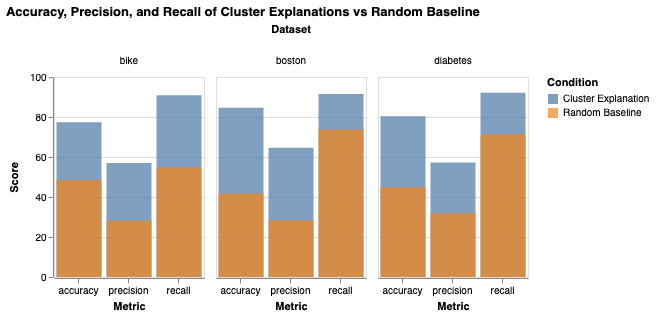

In [21]:
alt.Chart(explanation_accuracy_df).mark_bar(opacity=0.7).encode(
    x='Metric:O',
    y=alt.Y('Score:Q', stack=None),
    column='Dataset:N',
    color="Condition:N"
).properties(
    title="Accuracy, Precision, and Recall of Cluster Explanations vs Random Baseline",
    height=200, 
    width=150
).configure_axisBottom(labelAngle=0)

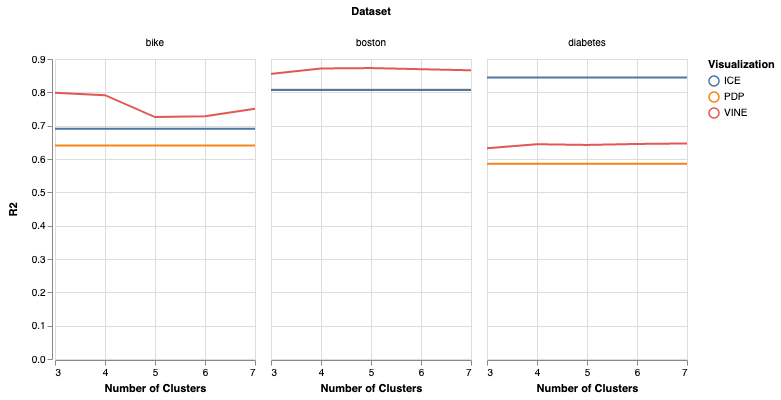

In [22]:
alt.Chart(information_ceiling_df).mark_line().encode(
    x="Number of Clusters",
    y="R2",
    color="Visualization"
).properties(
    height=300, 
    width=200
).facet(column="Dataset")

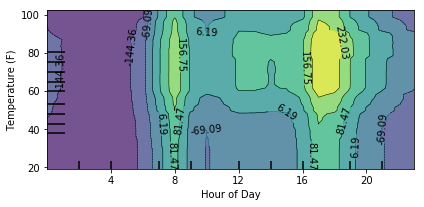

In [23]:
#Sample 2D PDP plot on bike dataset
sample_dfX, sample_y, sample_predictor = load_dataset(name="bike")
fig, axs = plot_partial_dependence(sample_predictor, sample_dfX, [(0,7)],
                                   feature_names=sample_dfX.columns,
                                   grid_resolution=60)

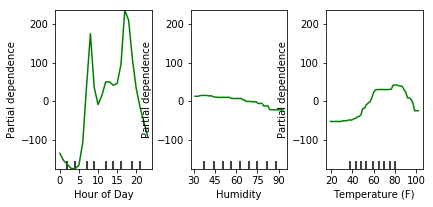

In [24]:
#Sample 1D PDP Plots on bike dataset
fig, axs = plot_partial_dependence(sample_predictor, sample_dfX, [0,1,7],
                                   feature_names=sample_dfX.columns,
                                   grid_resolution=60)